In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from itertools import groupby
import matplotlib.pyplot as plt
import pickle
import torch
import json
import seaborn as sns

In [2]:
def fasta_iter(fasta_name):
    """
    modified from Brent Pedersen
    Correct Way To Parse A Fasta File In Python
    given a fasta file. yield tuples of header, sequence
    """
    fh = open(fasta_name)

    # ditch the boolean (x[0]) and just keep the header or sequence since
    # we know they alternate.
    faiter = (x[1] for x in groupby(fh, lambda line: line[0] == ">"))
    
    for header in faiter:
        # drop the ">"
        headerStr = header.__next__()[1:].strip()
    
        # join all sequence lines to one.
        seq = "".join(s.strip() for s in faiter.__next__())
        #print(seq)

        yield (headerStr, seq)

In [3]:
fiter = fasta_iter('Neurospora_crassa/Neucr2_target_promoters.fa')
seq_ls=[]
for ff in fiter:
    headerStr, sequence = ff
    meta_dat = headerStr.split('::')
    data = meta_dat+[sequence]
    #print(sequence)
    seq_ls.append(data)

In [4]:
seq_ls = [[seq[0],seq[-1]] for seq in seq_ls]
seq_df = pd.DataFrame(seq_ls,columns=['id','sequence'])
seq_dict = {seq[0]:seq[1] for seq in seq_ls}
seq_df

,id,sequence
0,proteinId 1,TCCGATTCCTAGCGCCGATGTTATGGTCCACTTGTGTATGGTTTCC...
1,proteinId 2,CAACAGCCCAACAGCGCCCTGATGGTTGAAGACAGGACCCTGAGAA...
2,proteinId 3,GTGCGGGTTTGCTGTCTGTATGGTAGTGTACCTACCTTAAGTACTG...
3,proteinId 4,CGGCTGGAGATAAGGTACGGTGCCAAACCAATGGTTCACATGTCTT...
4,proteinId 5,GGAGGGGGTACGTGTTTAGCGAGGCAATCGGCACAATTCGAAGTAT...
...,...,...
9395,proteinId 10780,ACCCTTACCTACCATCCTACGTATGGACCTCTACCTCTACACGCAT...
9396,proteinId 10781,CCGCCCTTGAAGTAGTCACTGGCCGGGAACAGAACCCTTATGCCAA...
9397,proteinId 10782,CTTCACCGAGACCACTGATTCCAACATTGAGTTGCATTCAATGACC...
9398,proteinId 10783,TTGTTGGAAAGAGAATGGAGTTTGTTGCGCCTATGGTAAGGCGCTA...


In [5]:
len(seq_dict['proteinId 120'])

1000

# Preparing target data

In [6]:
df = pd.read_csv('Neurospora_crassa/Neucr2_Targets_expression.txt',sep='\t').drop(columns=['V126']) #drop a buggy column with only NAs
conditions = list(df.columns[3:])
min([v for v in df[conditions].values.reshape(len(df[conditions].values[0])*len(df[conditions].values))+0.005 if v>0.0])
df=df.dropna(axis=0) # get rid of rows with NAs
df

,proteinId,GeneID,annotation,No carbon 1,No carbon 2,No carbon 3,2% sucrose 1,2% sucrose 2,2% sucrose 3,2mM cellobiose 1,...,dNCU05414 1% Miscanthus 3,d08042 1% Avicel 1,d08042 1% Avicel 2,d08042 1% Avicel 3,d06971 1% Xylan 1,d06971 1% Xylan 2,d06971 1% Xylan 3,d07705 1% Avicel 1,d07705 1% Avicel 2,d07705 1% Avicel 3
0,1,NCU10129,hypothetical protein,29.44,29.49,25.13,6.64,5.83,6.41,8.63,...,20.48,25.85,25.65,25.57,30.53,31.18,30.58,25.85,24.63,28.26
1,2,NCU09901,hypothetical protein,6.03,6.32,5.91,9.34,9.26,9.22,4.29,...,5.33,4.76,4.05,5.05,3.24,3.10,3.07,4.52,4.21,5.15
2,3,NCU09903,elongation factor 3,14.03,14.02,13.78,25.90,27.06,25.20,1.64,...,8.83,6.14,4.92,5.88,1.53,1.55,1.74,5.95,6.48,6.31
3,4,NCU11134,hypothetical protein,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,5,NCU09904,"glucan 1,3-beta-glucosidase",1.35,1.52,1.56,1.44,1.56,1.55,1.13,...,5.17,2.30,2.20,2.22,5.47,5.25,5.44,1.58,2.08,2.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9395,10780,NCU05897,l-fucose permease,48.24,53.82,155.30,3.21,7.85,4.49,1947.57,...,919.27,98.30,86.27,97.22,711.06,712.24,759.81,63.02,66.11,72.72
9396,10781,NCU05899,flotillin domain-containing protein,7.14,8.23,28.24,17.24,20.91,20.10,289.22,...,37.87,12.64,6.92,13.72,39.59,38.57,29.26,10.41,10.17,8.89
9397,10782,NCU05900,hypothetical protein,37.28,39.00,70.50,24.27,31.20,29.49,316.38,...,81.05,41.86,39.86,40.63,69.47,72.63,62.49,34.38,34.29,40.73
9398,10783,NCU05901,hypothetical protein,6.81,7.62,7.40,4.93,5.29,5.31,7.01,...,4.59,6.49,7.29,7.21,3.58,3.63,4.67,6.67,6.75,6.53


In [7]:
df_n = df[['proteinId','GeneID','annotation']]
conds = list(set([cond[:-1] for cond in conditions if cond[-1] in ['1','2','3']]))
past = []
for cond in conds:
    if cond == 'dNCU01640 1% amylose ':
        rep1 = df['dNCU1640 1% amylose 1']
        rep2 = df['dNCU1640 1% amylose 2']
        rep3 = df['dNCU01640 1% amylose 3']
    elif cond =='dNCU1640 1% amylose ':
        continue
    elif cond == 'dNCU04211 2mM mannose ':
        rep1 = df['dNCU04211 2mM mannose 1']
        rep2 = df['dNCU04211 2mM mannose 2']
        rep3 = df['dNCU04211  2mM mannose 3']
    elif cond == 'dNCU04211  2mM mannose ':
        continue
    elif cond == 'dNCU04211 2mM mannose  ':
        continue
    elif cond == '1% Miscanthus ':
        rep1 = df['1% Miscanthus 1']
        rep2 = df['1% miscanthus 2']
        rep3 = df['1% miscanthus 3']
    elif cond == '1% miscanthus ':
        continue
    elif cond == '2mM mannitol ':
        rep1 = df['2mM manitol 1']
        rep2 = df['2mM mannitol 2']
        rep3 = df['2mM mannitol 3']
    elif cond == '2mM manitol ':
        continue
    
    elif cond == 'dNCU06173 1% avicel ':
        rep1 = df['dNCU06173 1% avicel 1']
        rep2 = df['dNCU06173 1% avicel 3.1']
        rep3 = df['dNCU06173 1% avicel 3']
    elif cond == 'dNCU06173 1% avicel 3.':
        continue
    
    elif cond == 'dNCU010080 1% energy cane ':
        rep1 = df['dNCU010080 1% energy cane-1 (418)']
        rep2 = df['dNCU010080 1% energy cane 2']
        rep3 = df['dNCU010080 1% energy cane 3']
    elif cond == 'dNCU010080 1% energy cane-1 (418':
        continue
    
    else:
        print(cond)
        rep1 = df[cond+'1']
        rep2 = df[cond+'2']
        rep3 = df[cond+'3']
    
    exp = (rep1.values + rep2.values + rep3.values)/3
    if past==list(exp):
        print('MISTAKE: ',cond)
    past = list(exp)
    df_n[cond]=exp
df_n

2mM cellobiose 
dNCU00808 1% arabinan 
1% citrus peel 
1% galactan 
2mM mannose 
1% rhamnogalacturonan 
dNCU00808 1% citrus peel 
1% galactomannan 
1% amylopectin 
dNCU03421 1% miscanthus 
dNCU01312 2mM Fucose 
dNCU09252 1% amylose 
dNCU08899 2mM rhamnose 
dNCU01209 1% mlg 
2mM galactose 
dNCU06920 1% galacturonic acid 
dNCU05909 1% xylan 
1% corn stover 
dNCU00289 1% amylose 
d08042 1% Avicel 
2mM sorbose 
dNCU01074 1% xylan 
dNCU02853 1% amylose 
dNCU04848 1% switchgrass 
2mM glucuronic acid 
dNCU00890 2mM mannobiose 
2mM fucose 
1% wing nut 
dNCU08055 2mM ribose 
dNCU00282 2mM fructose 
dNCU06173 1% Mix Link Glucan 
dNCU01386 1% energy cane 
dNCU03417 2mM ribose 
dNCU01154 1% pectin 
dNCU05414 1% Miscanthus 
dNCU07728 1% MLG 
2mM arabinose 
d06971 1% Xylan 
dNC04295 1% citrus peel 
1% Glucomannan 
dNCU09169 1% pectin 
1% esterified pectin 
dNCU00808 1% Galactan 
dNCU03643 2mM rhamnose 
d07705 1% Avicel 
2mM galacturonic acid 
dNCU02307 no carbon 
1% lignin 
1% xyloglucan 
1% switchg

<ipython-input-7-d3c234ed6f2c>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n[cond]=exp


,proteinId,GeneID,annotation,2mM cellobiose,dNCU00808 1% arabinan,1% citrus peel,dNCU010080 1% energy cane,dNCU06173 1% avicel,1% galactan,2mM mannose,...,1% amylose,dNCU04851 rhamnose 2mM,1% xylan,dNCU08634 1% amylose,dNCU02203 2mM ribose,1% energy cane,1% inulin,dNCU09169 1% citrus peel,2mM maltose,2mM ribose
0,1,NCU10129,hypothetical protein,9.103333,16.126667,23.613333,6.480000,9.426667,18.026667,20.716667,...,9.270000,21.196667,15.590000,22.933333,13.440000,10.840000,20.840000,14.936667,13.210000,14.113333
1,2,NCU09901,hypothetical protein,4.210000,3.570000,8.486667,4.260000,2.353333,5.196667,2.770000,...,7.813333,7.050000,5.906667,4.833333,4.513333,4.766667,4.156667,5.223333,6.890000,3.810000
2,3,NCU09903,elongation factor 3,1.246667,3.080000,6.373333,9.996667,4.253333,5.750000,0.566667,...,22.503333,10.383333,11.646667,4.560000,14.703333,4.680000,1.733333,8.293333,14.020000,10.366667
3,4,NCU11134,hypothetical protein,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,NCU09904,"glucan 1,3-beta-glucosidase",1.410000,2.486667,4.653333,2.860000,2.176667,1.543333,3.173333,...,4.923333,13.230000,6.913333,7.583333,16.213333,3.676667,2.856667,1.656667,4.140000,21.220000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9395,10780,NCU05897,l-fucose permease,1985.320000,485.330000,1806.036667,1000.680000,443.273333,240.806667,150.323333,...,1046.260000,314.096667,942.173333,1200.746667,175.933333,1345.866667,381.356667,2117.620000,1049.766667,229.016667
9396,10781,NCU05899,flotillin domain-containing protein,349.120000,20.090000,41.613333,91.746667,152.506667,44.420000,42.790000,...,197.356667,104.523333,48.413333,37.320000,156.026667,113.973333,55.026667,167.706667,28.396667,199.043333
9397,10782,NCU05900,hypothetical protein,374.383333,122.003333,125.386667,208.296667,254.516667,118.550000,127.170000,...,311.066667,160.983333,119.590000,91.113333,214.896667,151.026667,149.566667,329.823333,75.946667,211.463333
9398,10783,NCU05901,hypothetical protein,6.786667,7.003333,3.086667,4.343333,4.036667,6.536667,5.903333,...,2.950000,8.406667,5.493333,5.700000,6.210000,4.520000,6.766667,5.150000,7.683333,5.070000


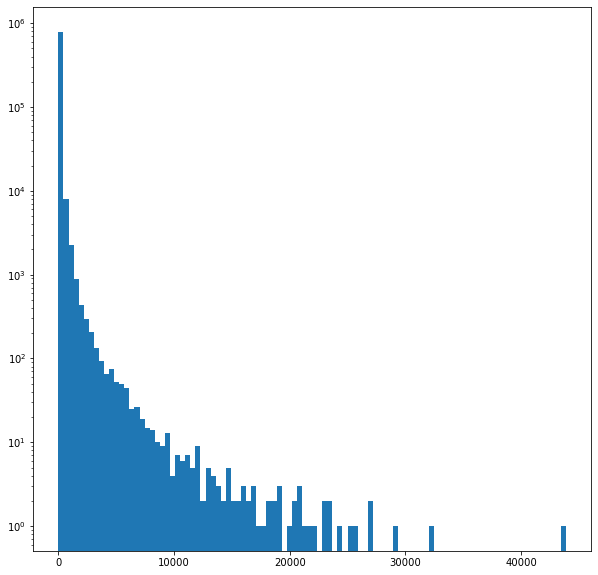

In [8]:
conditions = list(df_n.columns[3:])
plt.figure(figsize=(10, 10))
plt.hist(df_n[conditions].values.reshape(len(df_n[conditions].values[0])*len(df_n[conditions].values)),bins=100)
plt.yscale('log')
plt.savefig('final_figs/gene_expression_hist.pdf')
plt.show()

## Filter out genes that have mean expression below 0.05

In [9]:
exp_ar = df_n[conditions].values
print(len(exp_ar))
means = np.mean(exp_ar, axis=1)
print(len(means))
i=[]
for j in means:
    if j<0.05:
        i.append(False)
    else:
        i.append(True)
df_n = df_n[i]

9399
9399


## Filter out genes with coefficient of variation below 0.3

85
0.05019607843137255
8497 8497


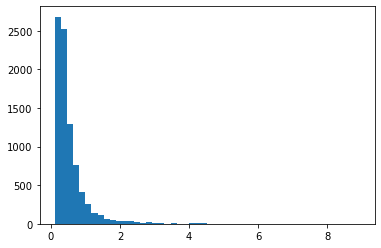

0.11701753383388576
0.539043487389969


In [10]:
print(len(conditions))
exp_ar = df_n[conditions].values
means = np.mean(exp_ar, axis=1)
print(min(means))
stds = np.std(exp_ar, axis=1)
print(len(exp_ar),len(means))
cv=stds/means
plt.hist(cv, bins=50)
plt.show()
print(min(cv))
print(np.mean(cv))

In [11]:
i=[]
for j in cv:
    if j<0.3:
        i.append(False)
    else:
        i.append(True)
df_cv = df_n[i]
df_cv[:5]

,proteinId,GeneID,annotation,2mM cellobiose,dNCU00808 1% arabinan,1% citrus peel,dNCU010080 1% energy cane,dNCU06173 1% avicel,1% galactan,2mM mannose,...,1% amylose,dNCU04851 rhamnose 2mM,1% xylan,dNCU08634 1% amylose,dNCU02203 2mM ribose,1% energy cane,1% inulin,dNCU09169 1% citrus peel,2mM maltose,2mM ribose
0,1,NCU10129,hypothetical protein,9.103333,16.126667,23.613333,6.480000,9.426667,18.026667,20.716667,...,9.270000,21.196667,15.590000,22.933333,13.440000,10.840000,20.840000,14.936667,13.21,14.113333
1,2,NCU09901,hypothetical protein,4.210000,3.570000,8.486667,4.260000,2.353333,5.196667,2.770000,...,7.813333,7.050000,5.906667,4.833333,4.513333,4.766667,4.156667,5.223333,6.89,3.810000
2,3,NCU09903,elongation factor 3,1.246667,3.080000,6.373333,9.996667,4.253333,5.750000,0.566667,...,22.503333,10.383333,11.646667,4.560000,14.703333,4.680000,1.733333,8.293333,14.02,10.366667
4,5,NCU09904,"glucan 1,3-beta-glucosidase",1.410000,2.486667,4.653333,2.860000,2.176667,1.543333,3.173333,...,4.923333,13.230000,6.913333,7.583333,16.213333,3.676667,2.856667,1.656667,4.14,21.220000
5,6,NCU09906,hypothetical protein,7.903333,13.110000,12.533333,11.470000,9.046667,10.933333,11.833333,...,16.296667,35.953333,28.433333,18.896667,60.290000,12.933333,13.186667,8.533333,17.60,80.990000


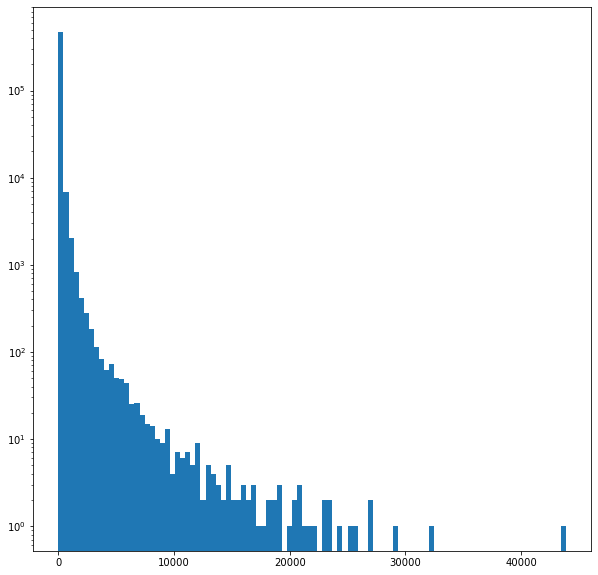

In [12]:
plt.figure(figsize=(10, 10))
plt.hist(df_cv[conditions].values.reshape(len(df_cv[conditions].values[0])*len(df_cv[conditions].values)),bins=100)
plt.yscale('log')
plt.savefig('final_figs/gene_expression_hist_filt05_cv3.pdf')
plt.show()

In [13]:
df_cv.to_csv('Neurospora_crassa/Neucr2_Targets_expression_av_filt05_filtcv3_new.txt',sep='\t',index=False)
df_cv

,proteinId,GeneID,annotation,2mM cellobiose,dNCU00808 1% arabinan,1% citrus peel,dNCU010080 1% energy cane,dNCU06173 1% avicel,1% galactan,2mM mannose,...,1% amylose,dNCU04851 rhamnose 2mM,1% xylan,dNCU08634 1% amylose,dNCU02203 2mM ribose,1% energy cane,1% inulin,dNCU09169 1% citrus peel,2mM maltose,2mM ribose
0,1,NCU10129,hypothetical protein,9.103333,16.126667,23.613333,6.480000,9.426667,18.026667,20.716667,...,9.270000,21.196667,15.590000,22.933333,13.440000,10.840000,20.840000,14.936667,13.210000,14.113333
1,2,NCU09901,hypothetical protein,4.210000,3.570000,8.486667,4.260000,2.353333,5.196667,2.770000,...,7.813333,7.050000,5.906667,4.833333,4.513333,4.766667,4.156667,5.223333,6.890000,3.810000
2,3,NCU09903,elongation factor 3,1.246667,3.080000,6.373333,9.996667,4.253333,5.750000,0.566667,...,22.503333,10.383333,11.646667,4.560000,14.703333,4.680000,1.733333,8.293333,14.020000,10.366667
4,5,NCU09904,"glucan 1,3-beta-glucosidase",1.410000,2.486667,4.653333,2.860000,2.176667,1.543333,3.173333,...,4.923333,13.230000,6.913333,7.583333,16.213333,3.676667,2.856667,1.656667,4.140000,21.220000
5,6,NCU09906,hypothetical protein,7.903333,13.110000,12.533333,11.470000,9.046667,10.933333,11.833333,...,16.296667,35.953333,28.433333,18.896667,60.290000,12.933333,13.186667,8.533333,17.600000,80.990000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9392,10777,NCU05894,hypothetical protein,2.093333,2.463333,5.450000,4.350000,2.793333,3.146667,1.103333,...,11.833333,6.650000,6.043333,4.426667,5.456667,2.980000,2.200000,5.860000,9.373333,4.693333
9394,10779,NCU05896,SesB,0.376667,2.653333,0.570000,0.656667,0.850000,1.506667,0.823333,...,1.476667,0.603333,0.910000,2.826667,1.203333,0.350000,0.820000,0.316667,1.603333,1.290000
9395,10780,NCU05897,l-fucose permease,1985.320000,485.330000,1806.036667,1000.680000,443.273333,240.806667,150.323333,...,1046.260000,314.096667,942.173333,1200.746667,175.933333,1345.866667,381.356667,2117.620000,1049.766667,229.016667
9396,10781,NCU05899,flotillin domain-containing protein,349.120000,20.090000,41.613333,91.746667,152.506667,44.420000,42.790000,...,197.356667,104.523333,48.413333,37.320000,156.026667,113.973333,55.026667,167.706667,28.396667,199.043333


# Preparing TF data

In [7]:
df = pd.read_csv('Neurospora_crassa/Neucr2_TFs_expression.txt',sep='\t')
conditions = list(df.columns[3:])
df_n = df[['proteinId','GeneID','annotation']]
conds = list(set([cond[:-1] for cond in conditions if cond[-1] in ['1','2','3']]))
for cond in conds:
    if cond == 'dNCU01640 1% amylose ':
        rep1 = df['dNCU1640 1% amylose 1']
        rep2 = df['dNCU1640 1% amylose 2']
        rep3 = df['dNCU01640 1% amylose 3']
    elif cond == 'dNCU04211 2mM mannose  ':
        pass
    elif cond =='dNCU1640 1% amylose ':
        pass
    elif cond == 'dNCU04211 2mM mannose ':
        rep1 = df['dNCU04211 2mM mannose 1']
        rep2 = df['dNCU04211 2mM mannose 2']
        rep3 = df['dNCU04211  2mM mannose 3']
    elif cond == 'dNCU04211  2mM mannose ':
        pass
    elif cond == '1% Miscanthus ':
        rep1 = df['1% Miscanthus 1']
        rep2 = df['1% miscanthus 2']
        rep3 = df['1% miscanthus 3']
    elif cond == '1% miscanthus ':
        pass
    elif cond == '2mM mannitol ':
        rep1 = df['2mM manitol 1']
        rep2 = df['2mM mannitol 2']
        rep3 = df['2mM mannitol 3']
    elif cond == '2mM manitol ':
        pass
    
    elif cond == 'dNCU06173 1% avicel ':
        rep1 = df['dNCU06173 1% avicel 1']
        rep2 = df['dNCU06173 1% avicel 3.1']
        rep3 = df['dNCU06173 1% avicel 3']
    elif cond == 'dNCU06173 1% avicel 3.':
        pass
    
    elif cond == 'dNCU010080 1% energy cane ':
        rep1 = df['dNCU010080 1% energy cane-1 (418)']
        rep2 = df['dNCU010080 1% energy cane 2']
        rep3 = df['dNCU010080 1% energy cane 3']
    elif cond == 'dNCU010080 1% energy cane-1 (418':
        pass
    
    else:
        print(cond)
        rep1 = df[cond+'1']
        rep2 = df[cond+'2']
        rep3 = df[cond+'3']
    
    exp = (rep1.values + rep2.values + rep3.values)/3
    df_n[cond]=exp

dNCU05909 1% xylan 
dNCU02203 2mM ribose 
1% rhamnogalacturonan 
1% corn stover 
2mM mannobiose 
2mM glucuronic acid 
d08042 1% Avicel 
1% galactan 
1% xyloglucan 
1% inulin 
No carbon 
dNCU09169 1% citrus peel 
dNCU00890 2mM mannobiose 
1% energy cane 
1% xylan 
1% amylopectin 
dNCU05024 1% galacturonic acid 
dNCU05414 1% Miscanthus 
dNCU01386 1% energy cane 
dNCU03643 2mM rhamnose 
2mM galacturonic acid 
dNCU00289 1% amylose 
dNCU02307 no carbon 
1% switchgrass 
dNCU00808 1% arabinan 
dNCU05909 2mM xylose 
2mM cellobiose 
2mM glycerol 
1% galactomannan 
1% Polygalacturonic acid 
1% amylose 
1% Glucomannan 
2mM fructose 
1% citrus peel 
dNCU00808 1% citrus peel 
2% sucrose 
dNCU03421 1% miscanthus 
dNC04295 1% citrus peel 
2mM maltose 
dNCU06920 1% galacturonic acid 
dNCU06173 1% Mix Link Glucan 
dNCU04848 1% switchgrass 
2mM galactose 
1% wing nut 
1% esterified pectin 
1% mixed linkage glucan 
dNCU01312 1% miscanthus 
dNCU00282 2mM fructose 
1% pectin 
2mM rhamnose 
d07705 1% Avicel

<ipython-input-7-8b4e318ba956>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n[cond]=exp


In [9]:
df_n.to_csv('Neurospora_crassa/Neucr2_TFs_expression_av.txt',sep='\t',index=False)